## 1. Importing Dependencies

In [48]:
import os
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## 2. Loading the Data

In [3]:
outcomes_df = pd.read_csv("../data/01-raw/actual_outcomes.csv")
features_df = pd.read_csv("../data/01-raw/customer_features.csv")
predictions_df = pd.read_csv("../data/01-raw/model_predictions.csv")
retention_df = pd.read_csv("../data/01-raw/retention_campaigns.csv")

#### I.**features_df** - Customer characteristics (5,000 customers)

In [4]:
features_df

,customer_id,account_age_days,age,county,avg_monthly_transactions,avg_transaction_value,wallet_balance,days_since_last_transaction
0,CUST00001,258,20,Nairobi,23.250880,2950.869798,38141.204637,0
1,CUST00002,221,55,Nakuru,14.064263,566.339924,2388.957682,6
2,CUST00003,43,39,Nairobi,4.117615,807.137278,905.826891,11
3,CUST00004,219,52,Nairobi,12.307753,1359.889306,3012.948239,0
4,CUST00005,805,63,Nairobi,23.795348,5586.158697,44845.328657,2
...,...,...,...,...,...,...,...,...
4995,CUST04996,570,31,Kiambu,3.703784,624.576881,2899.269832,16
4996,CUST04997,773,34,Kisumu,32.177664,2037.876018,11132.849408,3
4997,CUST04998,304,38,Kisumu,2.772267,801.531789,697.358383,7
4998,CUST04999,656,34,Kiambu,4.157972,907.384954,780.885453,16


#### II. **predictions_df** - Model output from 3 months ago

In [5]:
predictions_df

,customer_id,model_churn_probability,contacted,offer_type,responded
0,CUST00001,0.671539,True,Zero fee week,False
1,CUST00002,0.495458,False,NaN,False
2,CUST00003,0.770404,True,Zero fee week,False
3,CUST00004,0.555735,False,NaN,False
4,CUST00005,0.334440,False,NaN,False
...,...,...,...,...,...
4995,CUST04996,0.736526,True,Cashback 100 KES,True
4996,CUST04997,0.539012,False,NaN,False
4997,CUST04998,0.821544,True,Cashback 100 KES,False
4998,CUST04999,0.718044,True,Cashback 100 KES,False


#### III. **retention_df** - Who was contacted and how they responded

In [6]:
retention_df

,customer_id,contacted,offer_type,responded,actual_churned,model_churn_probability,true_segment
0,CUST00001,True,Zero fee week,False,False,0.671539,High Value Active
1,CUST00003,True,Zero fee week,False,False,0.770404,Casual User
2,CUST00006,True,Airtime bonus 50 KES,False,False,0.724132,Casual User
3,CUST00009,True,Cashback 100 KES,False,True,0.759133,Casual User
4,CUST00011,True,Zero fee week,False,True,0.846534,Recent Signup
...,...,...,...,...,...,...,...
2704,CUST04993,True,Cashback 100 KES,False,False,0.922074,Casual User
2705,CUST04995,True,Cashback 100 KES,False,False,0.837452,Casual User
2706,CUST04996,True,Cashback 100 KES,True,False,0.736526,Casual User
2707,CUST04998,True,Cashback 100 KES,False,True,0.821544,Recent Signup


#### IV. **outcomes_df** - Who actually churned (3 months later)

In [7]:
outcomes_df

,customer_id,actual_churned
0,CUST00001,False
1,CUST00002,False
2,CUST00003,False
3,CUST00004,False
4,CUST00005,False
...,...,...
4995,CUST04996,False
4996,CUST04997,False
4997,CUST04998,True
4998,CUST04999,False


## 3. Investigations

### <b> Phase I </b>

In this segment, I try investigate why an **87% accuracy model** is performing poorly in production, ie the Prediction and reality outcome mis-match. 

#### I. Data integration and Alignment

I'll join the features the prediction made 3 months ago and the actual results that happened since then.By joining the **prediction_df** and **outcome_df**,  I create a dataframe where every row has **model_churn_probability** and **actual_outcome**.

In [8]:
# merge the data
evaluation_df = pd.merge(predictions_df,outcomes_df, on='customer_id')

print(f"Rows in evaluation_df {len(evaluation_df)}")
evaluation_df

Rows in evaluation_df 5000


,customer_id,model_churn_probability,contacted,offer_type,responded,actual_churned
0,CUST00001,0.671539,True,Zero fee week,False,False
1,CUST00002,0.495458,False,NaN,False,False
2,CUST00003,0.770404,True,Zero fee week,False,False
3,CUST00004,0.555735,False,NaN,False,False
4,CUST00005,0.334440,False,NaN,False,False
...,...,...,...,...,...,...
4995,CUST04996,0.736526,True,Cashback 100 KES,True,False
4996,CUST04997,0.539012,False,NaN,False,False
4997,CUST04998,0.821544,True,Cashback 100 KES,False,True
4998,CUST04999,0.718044,True,Cashback 100 KES,False,False


In [9]:
# apply the production threshold
evaluation_df['predicted_churn'] = evaluation_df['model_churn_probability'] >= 0.6
evaluation_df

,customer_id,model_churn_probability,contacted,offer_type,responded,actual_churned,predicted_churn
0,CUST00001,0.671539,True,Zero fee week,False,False,True
1,CUST00002,0.495458,False,NaN,False,False,False
2,CUST00003,0.770404,True,Zero fee week,False,False,True
3,CUST00004,0.555735,False,NaN,False,False,False
4,CUST00005,0.334440,False,NaN,False,False,False
...,...,...,...,...,...,...,...
4995,CUST04996,0.736526,True,Cashback 100 KES,True,False,True
4996,CUST04997,0.539012,False,NaN,False,False,False
4997,CUST04998,0.821544,True,Cashback 100 KES,False,True,True
4998,CUST04999,0.718044,True,Cashback 100 KES,False,False,True


#### II. The Confusion Matrix

*   **True Positives (TP):** People the model said would churn, and they did. (Success)
    
*   **False Positives (FP):** People the model said would churn, but they stayed. (**The "Waste"**: We spent marketing budget on these people for no reason).
    
*   **False Negatives (FN):** People the model said would stay, but they churned. (**The "Leak"**: These are the people the Head of Retention is "hemorrhaging").
    
*   **True Negatives (TN):** People the model said would stay, and they stayed. (The "Safe" zone).

In [10]:
# Compute confusion matrix values
tn, fp, fn, tp = confusion_matrix(
    evaluation_df['actual_churned'],
    evaluation_df['predicted_churn']
).ravel()

# Create simple confusion matrix table
cm_table = pd.DataFrame(
    [[tn, fp],
     [fn, tp]],
    index=["Actual: Not Churned", "Actual: Churned"],
    columns=["Predicted: Not Churned", "Predicted: Churned"]
)
print(f"Total Customers: {len(evaluation_df)}")
print(cm_table)
print(f"Missed Churners (False Negatives) {fn}")
print(f"Wasted marketing (False Positive) {fp}")

Total Customers: 5000
                     Predicted: Not Churned  Predicted: Churned
Actual: Not Churned                    1601                2035
Actual: Churned                         197                1167
Missed Churners (False Negatives) 197
Wasted marketing (False Positive) 2035


#### III. Classification Report

In [11]:
# generate the report
print("---Classification Report---")
print(classification_report(evaluation_df['actual_churned'],evaluation_df['predicted_churn']))

---Classification Report---
              precision    recall  f1-score   support

       False       0.89      0.44      0.59      3636
        True       0.36      0.86      0.51      1364

    accuracy                           0.55      5000
   macro avg       0.63      0.65      0.55      5000
weighted avg       0.75      0.55      0.57      5000



1\. Accuracy (55%) - Percentage of all predictions that were correct
    
*   **Meaning:** Only 55% of the total predictions were right.
    
*   **Context:** The "87% accuracy" the consultancy promised is gone. This model is barely outperforming a coin flip because it is guessing "Churn" far too often.
    
2\. Precision (36%) - Of all the people the model claimed would **Churn**, how many actually did?
    
*   **Meaning:** When the model flags a churner, it is **wrong 64% of the time**.
    
*   **Context:** Head of Retention targeted **3,399 people the model said would churn** (TP + FP), but **2,035** of them (The Waste) had no intention of leaving. Free airtime and cashback  was sent to 2,035 loyal customers who didn't need it.
    
3\. Recall (86%) - Of all the people who actually churned, how many did the model catch?
    
*   **Meaning:** The model caught 86% of the people who actually left.
    
*   **Context:** Out of 1,364 actual churners, The model caught **1,167** (The Wins). The model didn't catch (hemorrhaged) **197** people (The Leak).
    
*   **The Catch:** To get this high safety rating, the model is being way too aggressive, causing the massive "Waste" mentioned above.
    
4\. F1-Score (0.51) - The harmonic mean of Precision and Recall. It’s a single number that punishes extreme values.
    
*   **Meaning:** The middle ground between Precision and Recall.
    
*   **Context:** Since the models Precision is terrible (0.36) and the Recall is good (0.86), the F1-score is low. A "healthy" model would ideally have both above 0.70.

#### IV. Precision-Recall Curve.

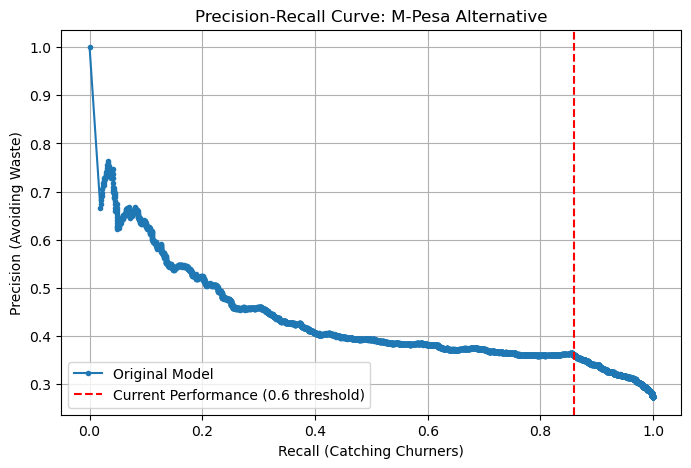

In [12]:
# Calculate the values for the curve
# Use the raw probabilities rather than the True/False labels
precision, recall, thresholds = precision_recall_curve(evaluation_df['actual_churned'], evaluation_df['model_churn_probability'])

# plotting
plt.figure(figsize=(8, 5))
plt.plot(recall,precision,marker='.',label='Original Model')
plt.xlabel('Recall (Catching Churners)')
plt.ylabel('Precision (Avoiding Waste)')
plt.title('Precision-Recall Curve: M-Pesa Alternative')
plt.axvline(x=0.86, color='r', linestyle='--', label='Current Performance (0.6 threshold)')
plt.legend()
plt.grid()
plt.show()

#### The Analysis
#### A. Safety vs Sustainability
The current threshold of **0.6** prioritizes **safety(Catching everyone)** over **Sustainability(Spending wisely)**
By trying to capture **86%** of all **potential Churners** the **precision** has dropped to around **36%**...ie. For every **10 people** the **model flags**, only about **3 or 4 actually churn**. This explains why the **Head of Retention** feels the model is targeting the **wrong people** because technically, it is.

#### B. Diminishing Returns
The Graph shows a "Flat Zone" between **40% and 86% recall**
Increasing the catch rate in this area doesn't make the model smarter, it just makes the net wider.
To catch those last few hundred churners, the company is forced to accept thousands of **False Positives** (loyal users who get freebies they didn't need). This is the "Waste" that is burning the marketing budget.

#### C. Sweet Spot
There is a spike on the far left of the graph where precision hits **0.75**. Instead of using a giant messy net that takes everything with it, this spike shows that we have a **Smaller, high-tech net**.It only looks at "Top 10-20%" of users who look the most suspicious, the ones who haven't logged in for days or just emptied their wallets. The team focuses on these "High-Certainty" users, and the response rate increases because we are finally targeting people who were on the verge of leaving.

#### V. Finding The "New" Threshold
We need to extract a probability value from the Precision-Recall data that maximizes the balance between catching churners and stopping the waste.

In [13]:
threshold_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precision[:-1],
    'Recall': recall[:-1]
})

# the threshold where precision hit ~0.75
sweet_spot = threshold_df[threshold_df['Precision'] >= 0.75].head(1)
print("Recommended High Certainty Threshold is")
print(sweet_spot)

Recommended High Certainty Threshold is
      Threshold  Precision    Recall
4939   0.990821   0.754098  0.033724


#### Interpreting the Results
To reach a **75% Precision(the sweet spot)**, we have to crank up the threshold to 0.99. At that level, the **Recall is only 3%**

Putting this into perspective; To be even reasonably sure the model is right, the model has to be **99% confident**. Even then, it only catches 3% of people who actually churned.

At 0.6 the model was catching people, but it's precision was so low (36%) because it was fundamentally unable to distinguish a "churner" from "Loyal user"

**Verdict:** Not to jump to conclusion, but the model might be the primary problem, not just the threshold. It's not just "over-sensitive", it's **unreliable**.


### <b> Phase II </b>

In this segment, we merge features_df to our existing evaluation_df to see what sets apart the various categories of customers

#### I. The Master Merge

In [14]:
# create the error label first
def categorize_error(row):
    if row['actual_churned'] == True and row['model_churn_probability'] >= 0.6:
        return 'True Positive (Win)'
    elif row['actual_churned'] == False and row['model_churn_probability'] >= 0.6:
        return 'False Positive (Waste)'
    elif row['actual_churned'] == True and row['model_churn_probability'] < 0.6:
        return 'False Negative (Leak)'
    else:
        return 'True Negative (Safe)'

evaluation_df['error_category'] = evaluation_df.apply(categorize_error, axis=1)

# Merge with features
master_df = pd.merge(evaluation_df, features_df, on='customer_id', how='inner')

print(len(master_df))
master_df

5000


,customer_id,model_churn_probability,contacted,offer_type,responded,actual_churned,predicted_churn,error_category,account_age_days,age,county,avg_monthly_transactions,avg_transaction_value,wallet_balance,days_since_last_transaction
0,CUST00001,0.671539,True,Zero fee week,False,False,True,False Positive (Waste),258,20,Nairobi,23.250880,2950.869798,38141.204637,0
1,CUST00002,0.495458,False,NaN,False,False,False,True Negative (Safe),221,55,Nakuru,14.064263,566.339924,2388.957682,6
2,CUST00003,0.770404,True,Zero fee week,False,False,True,False Positive (Waste),43,39,Nairobi,4.117615,807.137278,905.826891,11
3,CUST00004,0.555735,False,NaN,False,False,False,True Negative (Safe),219,52,Nairobi,12.307753,1359.889306,3012.948239,0
4,CUST00005,0.334440,False,NaN,False,False,False,True Negative (Safe),805,63,Nairobi,23.795348,5586.158697,44845.328657,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CUST04996,0.736526,True,Cashback 100 KES,True,False,True,False Positive (Waste),570,31,Kiambu,3.703784,624.576881,2899.269832,16
4996,CUST04997,0.539012,False,NaN,False,False,False,True Negative (Safe),773,34,Kisumu,32.177664,2037.876018,11132.849408,3
4997,CUST04998,0.821544,True,Cashback 100 KES,False,True,True,True Positive (Win),304,38,Kisumu,2.772267,801.531789,697.358383,7
4998,CUST04999,0.718044,True,Cashback 100 KES,False,False,True,False Positive (Waste),656,34,Kiambu,4.157972,907.384954,780.885453,16


#### II. Compare Waste to Wins

We need to see if the **False positives** (People we wrongly texted) look different from the **True positives**(People we correctly texted)

In [15]:
# looking at the average metrics of each group
feature_audit = master_df.groupby('error_category')[[
    'avg_monthly_transactions',
    'avg_transaction_value',
    'wallet_balance',
    'days_since_last_transaction',
    'account_age_days'
]].mean()
print("Customer Profile by Prediction Accuracy")
print(feature_audit)

Customer Profile by Prediction Accuracy
                        avg_monthly_transactions  avg_transaction_value  \
error_category                                                            
False Negative (Leak)                  15.322638            2620.929888   
False Positive (Waste)                  6.245315            1163.609567   
True Negative (Safe)                   21.526266            3157.046820   
True Positive (Win)                     5.333225            1550.919114   

                        wallet_balance  days_since_last_transaction  \
error_category                                                        
False Negative (Leak)      8375.026505                     7.390863   
False Positive (Waste)     1917.354933                    14.365602   
True Negative (Safe)      14793.754013                     2.919425   
True Positive (Win)        1252.325981                    23.976007   

                        account_age_days  
error_category                         

#### Insights

**False Positives** have an average of **14.3 days** since their last transaction, this shows that the model might be flagging people who haven't transacted in just **2 weeks**, for many users, a 14 day break is normal behavior, not churn.

**True Positives** Actual churners have been silent for 24 days on average. The model might be confusing "short break" with "leaving forever"

**False Negatives** The people the model missed, actually have very healthy accounts: **15 monthly transactions** and **8,375 KES balance**. The model assumed "Rich & Active = Loyal" and ignored their churn risk.

#### III. The Retention Campaigns

We'll need to merge the **retention_df**, it contains **Offer Type** and **Response** data, which reveals the human reaction to the model's prediction.

#### A. Merging

In [16]:
# merge master_df with retention_df
final_df = pd.merge(master_df, retention_df,on='customer_id', how='left')
final_df

,customer_id,model_churn_probability_x,contacted_x,offer_type_x,responded_x,actual_churned_x,predicted_churn,error_category,account_age_days,age,...,avg_monthly_transactions,avg_transaction_value,wallet_balance,days_since_last_transaction,contacted_y,offer_type_y,responded_y,actual_churned_y,model_churn_probability_y,true_segment
0,CUST00001,0.671539,True,Zero fee week,False,False,True,False Positive (Waste),258,20,...,23.250880,2950.869798,38141.204637,0,True,Zero fee week,False,False,0.671539,High Value Active
1,CUST00002,0.495458,False,NaN,False,False,False,True Negative (Safe),221,55,...,14.064263,566.339924,2388.957682,6,NaN,NaN,NaN,NaN,NaN,NaN
2,CUST00003,0.770404,True,Zero fee week,False,False,True,False Positive (Waste),43,39,...,4.117615,807.137278,905.826891,11,True,Zero fee week,False,False,0.770404,Casual User
3,CUST00004,0.555735,False,NaN,False,False,False,True Negative (Safe),219,52,...,12.307753,1359.889306,3012.948239,0,NaN,NaN,NaN,NaN,NaN,NaN
4,CUST00005,0.334440,False,NaN,False,False,False,True Negative (Safe),805,63,...,23.795348,5586.158697,44845.328657,2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CUST04996,0.736526,True,Cashback 100 KES,True,False,True,False Positive (Waste),570,31,...,3.703784,624.576881,2899.269832,16,True,Cashback 100 KES,True,False,0.736526,Casual User
4996,CUST04997,0.539012,False,NaN,False,False,False,True Negative (Safe),773,34,...,32.177664,2037.876018,11132.849408,3,NaN,NaN,NaN,NaN,NaN,NaN
4997,CUST04998,0.821544,True,Cashback 100 KES,False,True,True,True Positive (Win),304,38,...,2.772267,801.531789,697.358383,7,True,Cashback 100 KES,False,True,0.821544,Recent Signup
4998,CUST04999,0.718044,True,Cashback 100 KES,False,False,True,False Positive (Waste),656,34,...,4.157972,907.384954,780.885453,16,True,Cashback 100 KES,False,False,0.718044,Casual User


#### B. Cleaning up the duplicate columns which formed

In [17]:
# Create a single 'contacted' column using the campaign data as the priority
final_df['contacted'] = final_df['contacted_y'].fillna(final_df['contacted_x'])
final_df['offer_type'] = final_df['offer_type_y'].fillna(final_df['offer_type_x'])
final_df['responded'] = final_df['responded_y'].fillna(final_df['responded_x'])
final_df['actual_churned'] = final_df['actual_churned_x']

# Drop the messy suffixes
cols_to_drop = [c for c in final_df.columns if c.endswith('_x') or c.endswith('_y')]
final_df.drop(columns=cols_to_drop, inplace=True)

final_df

/tmp/ipykernel_16558/2654147336.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df['contacted'] = final_df['contacted_y'].fillna(final_df['contacted_x'])
/tmp/ipykernel_16558/2654147336.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df['responded'] = final_df['responded_y'].fillna(final_df['responded_x'])


,customer_id,predicted_churn,error_category,account_age_days,age,county,avg_monthly_transactions,avg_transaction_value,wallet_balance,days_since_last_transaction,true_segment,contacted,offer_type,responded,actual_churned
0,CUST00001,True,False Positive (Waste),258,20,Nairobi,23.250880,2950.869798,38141.204637,0,High Value Active,True,Zero fee week,False,False
1,CUST00002,False,True Negative (Safe),221,55,Nakuru,14.064263,566.339924,2388.957682,6,NaN,False,NaN,False,False
2,CUST00003,True,False Positive (Waste),43,39,Nairobi,4.117615,807.137278,905.826891,11,Casual User,True,Zero fee week,False,False
3,CUST00004,False,True Negative (Safe),219,52,Nairobi,12.307753,1359.889306,3012.948239,0,NaN,False,NaN,False,False
4,CUST00005,False,True Negative (Safe),805,63,Nairobi,23.795348,5586.158697,44845.328657,2,NaN,False,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CUST04996,True,False Positive (Waste),570,31,Kiambu,3.703784,624.576881,2899.269832,16,Casual User,True,Cashback 100 KES,True,False
4996,CUST04997,False,True Negative (Safe),773,34,Kisumu,32.177664,2037.876018,11132.849408,3,NaN,False,NaN,False,False
4997,CUST04998,True,True Positive (Win),304,38,Kisumu,2.772267,801.531789,697.358383,7,Recent Signup,True,Cashback 100 KES,False,True
4998,CUST04999,True,False Positive (Waste),656,34,Kiambu,4.157972,907.384954,780.885453,16,Casual User,True,Cashback 100 KES,False,False


In [18]:
# we only run this if there are still missing values after merging the x and y columns in the step above, otherwise, it does nothing
# Fill missing values for the 2300 people who were not contacted
final_df['contacted'] = final_df['contacted'].fillna(False)
final_df['responded'] = final_df['responded'].fillna(False)
final_df

,customer_id,predicted_churn,error_category,account_age_days,age,county,avg_monthly_transactions,avg_transaction_value,wallet_balance,days_since_last_transaction,true_segment,contacted,offer_type,responded,actual_churned
0,CUST00001,True,False Positive (Waste),258,20,Nairobi,23.250880,2950.869798,38141.204637,0,High Value Active,True,Zero fee week,False,False
1,CUST00002,False,True Negative (Safe),221,55,Nakuru,14.064263,566.339924,2388.957682,6,NaN,False,NaN,False,False
2,CUST00003,True,False Positive (Waste),43,39,Nairobi,4.117615,807.137278,905.826891,11,Casual User,True,Zero fee week,False,False
3,CUST00004,False,True Negative (Safe),219,52,Nairobi,12.307753,1359.889306,3012.948239,0,NaN,False,NaN,False,False
4,CUST00005,False,True Negative (Safe),805,63,Nairobi,23.795348,5586.158697,44845.328657,2,NaN,False,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CUST04996,True,False Positive (Waste),570,31,Kiambu,3.703784,624.576881,2899.269832,16,Casual User,True,Cashback 100 KES,True,False
4996,CUST04997,False,True Negative (Safe),773,34,Kisumu,32.177664,2037.876018,11132.849408,3,NaN,False,NaN,False,False
4997,CUST04998,True,True Positive (Win),304,38,Kisumu,2.772267,801.531789,697.358383,7,Recent Signup,True,Cashback 100 KES,False,True
4998,CUST04999,True,False Positive (Waste),656,34,Kiambu,4.157972,907.384954,780.885453,16,Casual User,True,Cashback 100 KES,False,False


#### C. Calculating the Effectiveness of each offer

In [19]:
# Filtering only those who were contacted
contacted_df = final_df[final_df['contacted']== True].copy()

# Success = they responded and they did not churn
contacted_df['success'] = (contacted_df['responded']) & (contacted_df['actual_churned'] == False)

# Grouping by offer to see which one wins
offer_success = contacted_df.groupby('offer_type')['success'].mean().sort_values(ascending=False)

print("Campaign success Rate")
print(offer_success)

Campaign success Rate
offer_type
Airtime bonus 50 KES    0.098831
Cashback 100 KES        0.090909
Zero fee week           0.090110
Name: success, dtype: float64


A **9% Success Rate** across the board means that regardless of the offer, **91%** of the intervention efforts were failing. The Retention team is spamming people who don't need help while missing VIPS who actually do.

## 4. Exploratory Data Analysis

I'll now merge Customer_features.csv with actual_outcomes.csv using customer_id, define the y variable, do a train test split on the merged data, do some feature engineering

#### I. Merging the features and outcome dataframes

In [20]:
# 1. Merging the dataframes on customer_id
eda_df = pd.merge(features_df, outcomes_df, on='customer_id', how='inner')
eda_df

,customer_id,account_age_days,age,county,avg_monthly_transactions,avg_transaction_value,wallet_balance,days_since_last_transaction,actual_churned
0,CUST00001,258,20,Nairobi,23.250880,2950.869798,38141.204637,0,False
1,CUST00002,221,55,Nakuru,14.064263,566.339924,2388.957682,6,False
2,CUST00003,43,39,Nairobi,4.117615,807.137278,905.826891,11,False
3,CUST00004,219,52,Nairobi,12.307753,1359.889306,3012.948239,0,False
4,CUST00005,805,63,Nairobi,23.795348,5586.158697,44845.328657,2,False
...,...,...,...,...,...,...,...,...,...
4995,CUST04996,570,31,Kiambu,3.703784,624.576881,2899.269832,16,False
4996,CUST04997,773,34,Kisumu,32.177664,2037.876018,11132.849408,3,False
4997,CUST04998,304,38,Kisumu,2.772267,801.531789,697.358383,7,True
4998,CUST04999,656,34,Kiambu,4.157972,907.384954,780.885453,16,False


##### Columns present and their types

In [21]:
eda_df.dtypes

customer_id                     object
account_age_days                 int64
age                              int64
county                          object
avg_monthly_transactions       float64
avg_transaction_value          float64
wallet_balance                 float64
days_since_last_transaction      int64
actual_churned                    bool
dtype: object

#### II. Dropping customer_id

I'm dropping customer_id since it has no predictive power

In [22]:
eda_df = eda_df.drop('customer_id', axis=1)
eda_df.columns

Index(['account_age_days', 'age', 'county', 'avg_monthly_transactions',
       'avg_transaction_value', 'wallet_balance',
       'days_since_last_transaction', 'actual_churned'],
      dtype='object')

#### III. Handling County(One Hot encoding)

In [23]:
eda_df['county'].unique()

array(['Nairobi', 'Nakuru', 'Uasin Gishu', 'Kisumu', 'Kiambu', 'Mombasa',
       'Machakos'], dtype=object)

since we only have 7 counties, we will use one hot encoding 

In [24]:
# 1. initialization
encoder = OneHotEncoder(sparse_output=False, drop='first')

# 2. Fit and Transform the 'county' column
county_encoded = encoder.fit_transform(eda_df[['county']])

# 3. clear column names
encoded_cols = encoder.get_feature_names_out(['county'])
df_county_vars = pd.DataFrame(county_encoded, columns=encoded_cols, index=eda_df.index)

# 4. Merge back and drop the original text column
encoded_eda_df = pd.concat([eda_df.drop('county', axis=1), df_county_vars], axis=1)

print(f"New shape: {encoded_eda_df.shape}")
encoded_eda_df

New shape: (5000, 13)


,account_age_days,age,avg_monthly_transactions,avg_transaction_value,wallet_balance,days_since_last_transaction,actual_churned,county_Kisumu,county_Machakos,county_Mombasa,county_Nairobi,county_Nakuru,county_Uasin Gishu
0,258,20,23.250880,2950.869798,38141.204637,0,False,0.0,0.0,0.0,1.0,0.0,0.0
1,221,55,14.064263,566.339924,2388.957682,6,False,0.0,0.0,0.0,0.0,1.0,0.0
2,43,39,4.117615,807.137278,905.826891,11,False,0.0,0.0,0.0,1.0,0.0,0.0
3,219,52,12.307753,1359.889306,3012.948239,0,False,0.0,0.0,0.0,1.0,0.0,0.0
4,805,63,23.795348,5586.158697,44845.328657,2,False,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,570,31,3.703784,624.576881,2899.269832,16,False,0.0,0.0,0.0,0.0,0.0,0.0
4996,773,34,32.177664,2037.876018,11132.849408,3,False,1.0,0.0,0.0,0.0,0.0,0.0
4997,304,38,2.772267,801.531789,697.358383,7,True,1.0,0.0,0.0,0.0,0.0,0.0
4998,656,34,4.157972,907.384954,780.885453,16,False,0.0,0.0,0.0,0.0,0.0,0.0


#### IV. Dependent and Independent Variables

In [25]:
X = encoded_eda_df.drop('actual_churned', axis=1)

# target Variable
y = encoded_eda_df['actual_churned']

#### V. Train test Split

In [26]:
# the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  
)

#### VI. Correlation Matrix

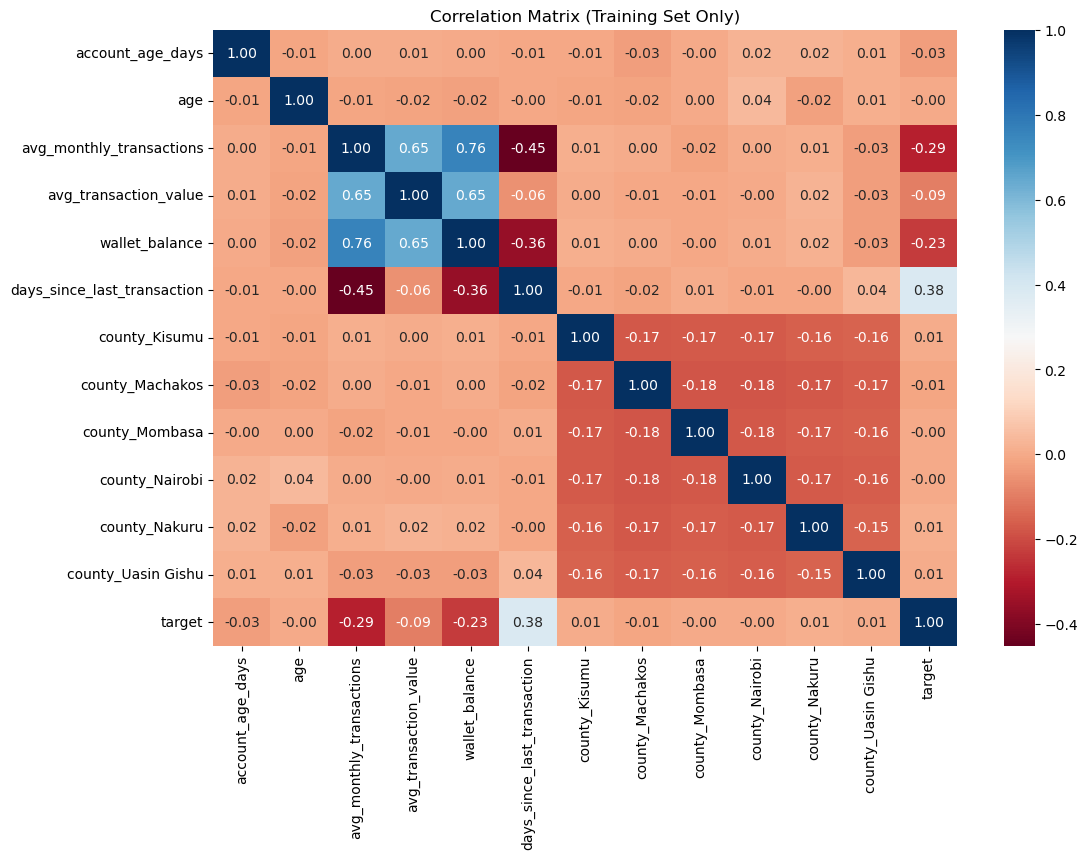

In [27]:
# Temporarily join them to see how features relate to the target
train_data = X_train.copy()
train_data['target'] = y_train

# Generate the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='RdBu', fmt='.2f')
plt.title("Correlation Matrix (Training Set Only)")
plt.show()

##### 1\. The strongest churn signals

If you focus on the row (or column) for the target variable, a few features clearly move with churn:

*   **days\_since\_last\_transaction (0.38)** This is the strongest positive relationship. The longer someone has gone without transacting, the more likely they are to churn. That’s pretty standard behavior in churn analysis.
    
*   **avg\_monthly\_transactions (-0.29)** This shows a solid negative relationship. Customers who transact more frequently are less likely to churn.
    
*   **wallet\_balance (-0.23)** Lower balances are linked to higher churn. Customers who keep more money in their wallet tend to stay.
    

Together, these three features carry most of the linear signal related to churn.

##### 2\. Overlapping features (multicollinearity)

In the feature-to-feature section of the heatmap, there are a few strong internal correlations:

*   **avg\_monthly\_transactions vs. wallet\_balance (0.76)** Customers who transact more often also tend to maintain higher balances.
    
*   **avg\_monthly\_transactions vs. avg\_transaction\_value (0.65)** Another strong relationship.
    

For tree-based models like XGBoost, this isn’t a major issue. Trees handle correlated variables fairly well.

##### 3\. Features that don’t show much linear impact

Some variables barely move with churn:

*   **age and account\_age\_days (-0.00 to -0.03)** There’s almost no linear relationship here. Based on correlation alone, customer age or how long they’ve had the account doesn’t directly predict churn.
    
*   **county (around 0.01)** Location doesn’t appear to be a strong driver either. There’s no obvious “churn-heavy” county.
    

##### 4\. Clues about interaction

There’s also a noticeable **\-0.45** relationship between days\_since\_last\_transaction and avg\_monthly\_transactions. That fits logically: highly active users will naturally have fewer days since their last transaction.

Overall, the heatmap confirms that behavioral activity variables are doing most of the heavy lifting, while demographic and location features seem less influential, at least from a linear perspective.

## 5. Initialize and Train XGBoost Model

#### I. Ratio of Churned Vs Not Churned

In [28]:
print(y_train.value_counts(normalize=True))

actual_churned
False    0.72725
True     0.27275
Name: proportion, dtype: float64


Based on the results, the ratio is roughly 2.66 ie 72.725/27.275, this ratio will assist in tweaking the model to understand that identifying a "True" (Churner) is about 2.6 times more important than identifying a "False."

#### II. Initialize and Train the XGBoost Model

In [29]:
# Initialize the model with the calculated weight
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=2.66, 
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 2. Train the model
model.fit(X_train, y_train)

# 3. Make predictions
y_pred = model.predict(X_test)

/home/kobey/anaconda3/envs/califonia_housing_prices/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [05:42:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#### III. Evaluation

##### Confusion Matrix

In [30]:
# Compute confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Create simple confusion matrix table
cm_table = pd.DataFrame(
    [[tn, fp],
     [fn, tp]],
    index=["Actual: Not Churned", "Actual: Churned"],
    columns=["Predicted: Not Churned", "Predicted: Churned"]
)
print(f"Total Customers: {len(evaluation_df)}")
print(cm_table)
print(f"Missed Churners (False Negatives) {fn}")
print(f"Wasted marketing (False Positive) {fp}")

Total Customers: 5000
                     Predicted: Not Churned  Predicted: Churned
Actual: Not Churned                     537                 190
Actual: Churned                         109                 164
Missed Churners (False Negatives) 109
Wasted marketing (False Positive) 190


##### The Confusion Matrix Breakdown

*   **True Negatives (537):** We correctly identified 537 people who stayed.
    
*   **True Positives (164):** We correctly caught 164 people who were going to churn.
    
*   **False Negatives (109):** These are the "silent departures", people the model said would stay, but they actually left.
    
*   **False Positives (190):** These are "false alarms." The model flagged them as churners, but they are actually loyal.

##### Classification Report

In [31]:
# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))


--- Classification Report ---
              precision    recall  f1-score   support

       False       0.83      0.74      0.78       727
        True       0.46      0.60      0.52       273

    accuracy                           0.70      1000
   macro avg       0.65      0.67      0.65      1000
weighted avg       0.73      0.70      0.71      1000



##### Precision vs. Recall (The Trade-off)

*   **Recall (0.60):** We are catching **60%** of all churners. In business terms, if 100 people are about to leave, we’re stopping 60 of them at the door. Not bad for a start!
    
*   **Precision (0.46):** When the model says "This person is churning," it’s only right **46%** of the time. We are currently flagging a lot of happy customers as churn risks.

As a first model, these results are not bad, but we can make them better

## 6. Feature Engineering

#### I. Feature Engineering

The correlation Matrix showed that age, account_age and county weren't doing much. We should create interaction features to give the model better clues

In [33]:
encoded_eda_df.columns

Index(['account_age_days', 'age', 'avg_monthly_transactions',
       'avg_transaction_value', 'wallet_balance',
       'days_since_last_transaction', 'actual_churned', 'county_Kisumu',
       'county_Machakos', 'county_Mombasa', 'county_Nairobi', 'county_Nakuru',
       'county_Uasin Gishu'],
      dtype='object')

In [37]:
# A copy to keep things clean
engineered_df = encoded_eda_df.copy()

# 1. Transactions remaining in balance (Handling division by zero with +1)
engineered_df['tx_coverage'] = engineered_df['wallet_balance']/(engineered_df['avg_transaction_value'] + 1)

# 2. Activity Intensity
engineered_df['activity_intensity'] = engineered_df['avg_monthly_transactions']/ (engineered_df['account_age_days'] + 1)

# 3. Deviation From typical behavior
# Average days between transactions = 30 / avg_monthly_transactions
# We check how many "usual cycles" they have missed
engineered_df['behavioral_deviation'] = engineered_df['days_since_last_transaction'] * (engineered_df['avg_monthly_transactions'] / 30)

# Re-split with the new features
X_new = engineered_df.drop(['actual_churned'], axis=1)
y_new = engineered_df['actual_churned']

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
    X_new, y_new, test_size=0.2, random_state=42, stratify=y_new
)

In [38]:
engineered_df.columns

Index(['account_age_days', 'age', 'avg_monthly_transactions',
       'avg_transaction_value', 'wallet_balance',
       'days_since_last_transaction', 'actual_churned', 'county_Kisumu',
       'county_Machakos', 'county_Mombasa', 'county_Nairobi', 'county_Nakuru',
       'county_Uasin Gishu', 'tx_coverage', 'activity_intensity',
       'behavioral_deviation'],
      dtype='object')

#### II. Retraining on New Features

In [39]:
# Initializing the model with the same baseline parameters
model_v2 = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=2.66, 
    random_state=42,
    eval_metric='logloss'
)

# Fit on the new training data (X_train_n contains the 3 new features)
model_v2.fit(X_train_n, y_train_n)

# Predict on the new test set
y_pred_v2 = model_v2.predict(X_test_n)

In [40]:
# Evaluate the results
print("--- New Confusion Matrix ---")
print(confusion_matrix(y_test_n, y_pred_v2))

print("\n--- New Classification Report ---")
print(classification_report(y_test_n, y_pred_v2))

--- New Confusion Matrix ---
[[534 193]
 [108 165]]

--- New Classification Report ---
              precision    recall  f1-score   support

       False       0.83      0.73      0.78       727
        True       0.46      0.60      0.52       273

    accuracy                           0.70      1000
   macro avg       0.65      0.67      0.65      1000
weighted avg       0.73      0.70      0.71      1000



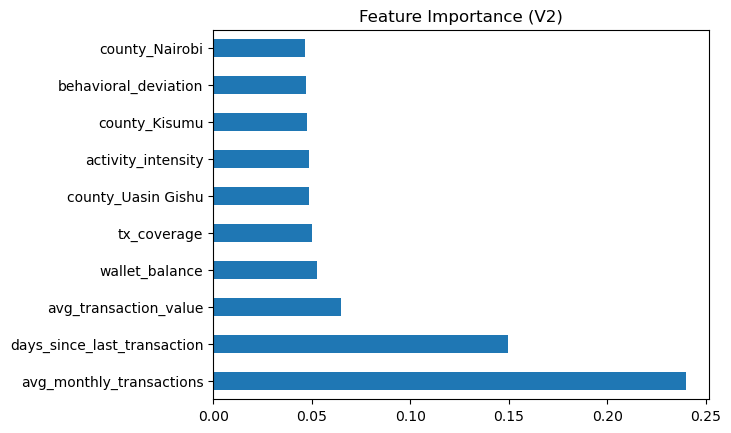

In [41]:
feat_importances = pd.Series(model_v2.feature_importances_, index=X_new.columns)
feat_importances.nlargest(10).plot(kind='barh', title='Feature Importance (V2)')
plt.show()

At this point in my modelling, i tried feature engineering hoping it would make improvements on the baseline XGBoost model we ran first, but we gained exactly one more true positive(165 vs 164). Feature engineering didn't improve the model, so i'll try adjusting the threshold

## 7. Threshold Adjustment

In [44]:
# Instead of model.predict(), get the raw probabilities
y_probs = model_v2.predict_proba(X_test_n)[:, 1]

# Set a stricter threshold (e.g., 0.65)
y_pred_strict = (y_probs > 0.6).astype(int)

print("--- Stricter Threshold (0.65) ---")
print(confusion_matrix(y_test_n, y_pred_v2))
print(classification_report(y_test_n, y_pred_strict))

--- Stricter Threshold (0.65) ---
[[534 193]
 [108 165]]
              precision    recall  f1-score   support

       False       0.81      0.84      0.82       727
        True       0.53      0.48      0.50       273

    accuracy                           0.74      1000
   macro avg       0.67      0.66      0.66      1000
weighted avg       0.73      0.74      0.74      1000



## 8. Hyperparameter Tuning

#### I. GridSearch

In [49]:
# Define a search space
param_grid = {
    'max_depth': [3, 4, 5],                
    'learning_rate': [0.03, 0.05, 0.07],    
    'n_estimators': [100, 150, 200],
    'subsample': [0.8],                     
    'colsample_bytree': [0.8],
    'gamma': [0.1, 0.2]
}
# Initialize Grid Search
grid_search = GridSearchCV(
    XGBClassifier(scale_pos_weight=2.66, random_state=42, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the search
grid_search.fit(X_train_n, y_train_n)

# best version
final_xgb_model = grid_search.best_estimator_
print(f"Best Grid Params: {grid_search.best_params_}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/kobey/anaconda3/envs/califonia_housing_prices/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/kobey/anaconda3/envs/califonia_housing_prices/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/kobey/anaconda3/envs/califonia_housing_prices/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated f

Best Grid Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.8}


#### II. Running using best parameters

In [50]:
# 1. Predict with the Grid Search optimized model
y_pred_final = final_xgb_model.predict(X_test_n)

# 2. Final Report
print("--- Final Grid Search Model Results ---")
print(confusion_matrix(y_test_n, y_pred_final))
print(classification_report(y_test_n, y_pred_final))

--- Final Grid Search Model Results ---
[[515 212]
 [ 93 180]]
              precision    recall  f1-score   support

       False       0.85      0.71      0.77       727
        True       0.46      0.66      0.54       273

    accuracy                           0.69      1000
   macro avg       0.65      0.68      0.66      1000
weighted avg       0.74      0.69      0.71      1000



This is the best model i could come up with, Catches 66% of churners (Recall). Is correct 46% of the time it flags someone (Precision). Of course i do understand that one of the limitation i had was the size of the training data, the original was 45000, while mine was a mere 5000, but as per the classification report the precision improved by 10% and f1 score improved by 3% accuracy is also at 69%, so i guess it somewhat a win.
